In [1]:
try:
    output_filepath
except:
    output_filepath = 's3://workspaces-clarity-mgmt-pro/jaime.oliver/misc/social_capital/data/processed/'

In [2]:
import os
from pathlib import Path

import pandas as pd
import numpy as np

import patsy
import statsmodels.api as sm
from linearmodels import PanelOLS
from linearmodels import RandomEffects
from linearmodels.panel import BetweenOLS, PooledOLS, compare

from linearmodels import IV2SLS

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})


In [3]:
data_path = os.path.join(output_filepath, 'panel_data.parquet')
df_model = pd.read_parquet(data_path)

df_model = df_model[df_model.year.between(2001, 2016)]

df_model['human_authorities_cero'] = np.isclose(df_model.human_authorities, 0)
df_model['receiving_cuntries'] = df_model.groupby('country').human_authorities_cero.transform(lambda x: sum(x)<len(x))
#df_model = df_model[df_model.receiving_cuntries]

centralities = ['hubs', 'authorities','pagerank', 'gfi', 'bridging', 'favor']
networks = ['financial', 'goods', 'human']
networks = ['financial', 'goods', 'estimated_human']

In [4]:
df_model[df_model.receiving_cuntries].country.unique()

array(['AUS', 'AUT', 'BEL', 'CAN', 'CHE', 'CHL', 'CZE', 'DEU', 'DNK',
       'ESP', 'EST', 'FIN', 'FRA', 'GBR', 'GRC', 'HUN', 'IRL', 'ISL',
       'ISR', 'ITA', 'JPN', 'KOR', 'LUX', 'LVA', 'MEX', 'NLD', 'NOR',
       'NZL', 'POL', 'PRT', 'SVK', 'SVN', 'SWE', 'TUR', 'USA'],
      dtype=object)

In [5]:
[f'{n}_{c}' for c in centralities for n in networks]

['financial_hubs',
 'goods_hubs',
 'estimated_human_hubs',
 'financial_authorities',
 'goods_authorities',
 'estimated_human_authorities',
 'financial_pagerank',
 'goods_pagerank',
 'estimated_human_pagerank',
 'financial_gfi',
 'goods_gfi',
 'estimated_human_gfi',
 'financial_bridging',
 'goods_bridging',
 'estimated_human_bridging',
 'financial_favor',
 'goods_favor',
 'estimated_human_favor']

In [6]:
corr_cols = ['log_output', 'log_gdp', 'gini', 'log_GFCF', 'log_wkn_population'] + [f'{n}_{c}' for c in centralities for n in networks]

for c in [f'{n}_{c}' for c in centralities for n in networks]:
    df_model[c] = df_model[c].map(lambda x: np.log1p(x*1.e8))

df_model[['country', 'year'] + corr_cols].describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
country,2731,171,ALB,16,NaN,NaN,NaN,NaN,NaN,NaN,NaN
year,2731,NaN,NaN,NaN,2008.49,4.60842,2001,2004,2008,2012,2016
log_output,2731,NaN,NaN,NaN,17.9249,2.23266,10.8685,16.3944,17.6934,19.6174,24.1941
log_gdp,2731,NaN,NaN,NaN,17.1583,2.32031,7.3328,15.6644,16.9492,18.884,23.5039
gini,359,NaN,NaN,NaN,0.319203,0.0594887,0.234,0.2695,0.315,0.348,0.62
log_GFCF,2511,NaN,NaN,NaN,22.8906,2.58599,0,21.468,22.7439,24.5476,29.1997
log_wkn_population,2731,NaN,NaN,NaN,15.1326,1.71139,10.7088,14.1218,15.1731,16.2155,20.4811
financial_hubs,2731,NaN,NaN,NaN,12.8838,0.71538,10.2929,12.3853,12.8415,13.3716,15.8608
goods_hubs,2731,NaN,NaN,NaN,12.1586,1.19763,8.97596,11.4028,12.1206,12.9755,17.0341
estimated_human_hubs,2683,NaN,NaN,NaN,11.699,1.76982,7.51901,10.3831,11.9296,12.9384,17.45


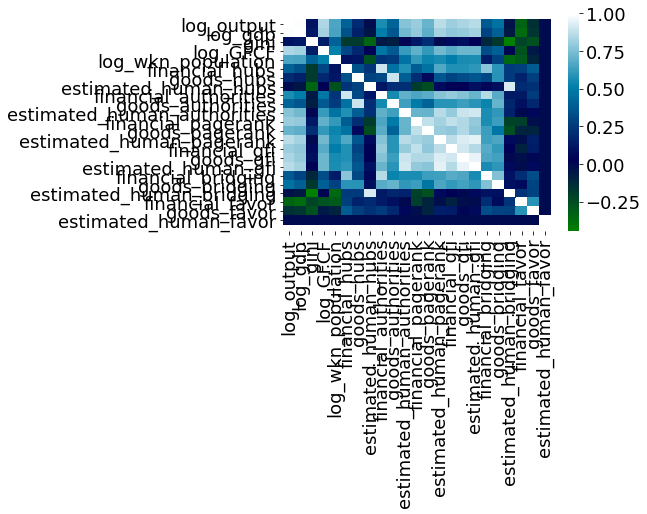

In [7]:
plt.rcParams.update({'font.size': 18})

corr = df_model[corr_cols].corr()

# plot the heatmap
sns.heatmap(corr, cmap="ocean",
        xticklabels=corr.columns,
        yticklabels=corr.columns,)

# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.7 # Add 0.5 to the bottom
t -= 0.7 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show() # ta-da!

## Variable selection
Some of the social capital variables we want to include are highly correlated --> need to reduce dimensionality in order to avoid multicolinearity


In [8]:
all_terms_list = [f'{n}_{c}' for c in centralities for n in networks]

In [9]:
from scipy.stats import pearsonr
import statsmodels.api as sm

def corrfunc(x,y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    plt.rcParams.update({'font.size': 15})

    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    # Unicode for lowercase rho (ρ)
    rho = '\u03C1'
    ax.annotate(f'{rho} = {r:.2f}', xy=(.5, .1), xycoords=ax.transAxes)

def r2func(x,y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    plt.rcParams.update({'font.size': 15})

    x = sm.add_constant(x)
    model = sm.OLS(y,x)
    results = model.fit()
    r2 = results.rsquared

    ax = ax or plt.gca()
    # Unicode for lowercase rho (ρ)
    ax.annotate(f'$R^2$= {r2:.2f}', xy=(.5, .1), xycoords=ax.transAxes)



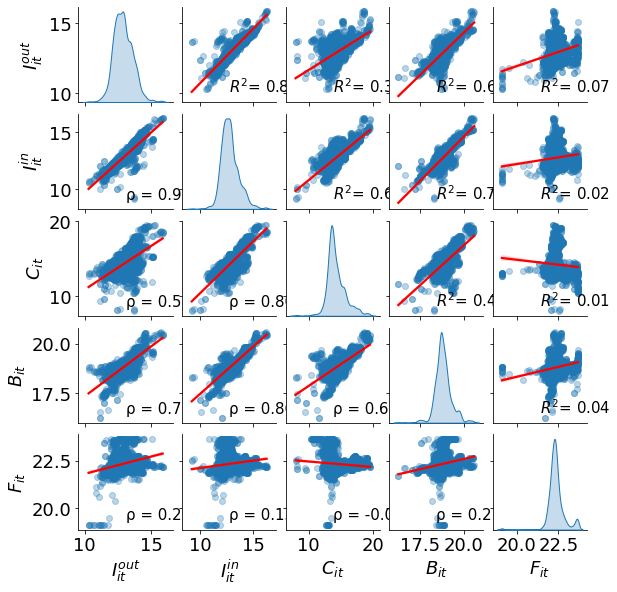

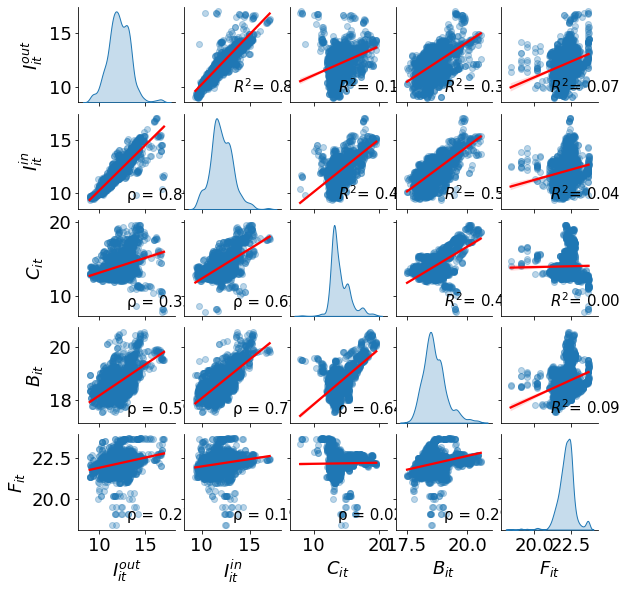

/home/ubuntu/.local/lib/python3.7/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


ValueError: array must not contain infs or NaNs

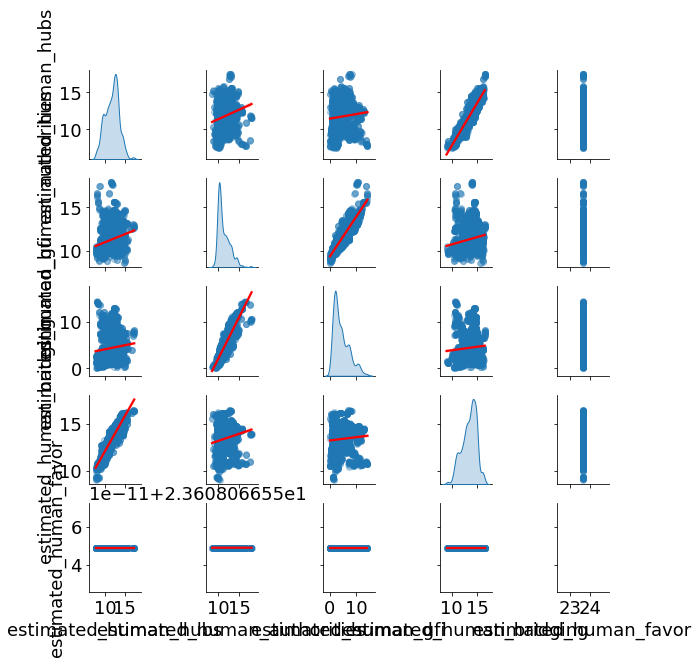

In [10]:
for n in networks:
    corr_cols = [f'{n}_{c}' for c in ['hubs', 'authorities', 'gfi', 'bridging', 'favor']] 

    plt.rcParams.update({'font.size': 18})

    g = sns.pairplot(df_model[corr_cols], kind='reg', diag_kind = 'kde', plot_kws={'scatter_kws': {'alpha': 0.3}, 'line_kws':{'color':'red'}})
    g.fig.set_size_inches(8,8)
    g.map_lower(corrfunc)
    g.map_upper(r2func)

    names = dict(zip(corr_cols, ['$I_{it}^{out}$', '$I_{it}^{in}$', '$C_{it}$', '$B_{it}$', '$F_{it}$'] ))

    plt.rcParams.update({'font.size': 18})
    for i in range(len(corr_cols)):
        for j in range(len(corr_cols)):
            xlabel = g.axes[i][j].get_xlabel()
            ylabel = g.axes[i][j].get_ylabel()
            if xlabel in names.keys():
                g.axes[i][j].set_xlabel(names[xlabel])
            if ylabel in names.keys():
                g.axes[i][j].set_ylabel(names[ylabel])

    save_to = os.path.join(Path(os.getcwd()).parent.resolve(), 'reports', 'figures', f'{n}_social_capital_multicolinearity.png')
    plt.savefig(save_to)    
    plt.show()

## Simultaneous model capital and migration

In [11]:
all_terms_regression = ' + '.join(all_terms_list)

In [12]:
df_model[all_terms_list].isnull().mean()

financial_hubs                 0.000000
goods_hubs                     0.000000
estimated_human_hubs           0.017576
financial_authorities          0.000000
goods_authorities              0.000000
estimated_human_authorities    0.017576
financial_pagerank             0.000000
goods_pagerank                 0.000000
estimated_human_pagerank       0.017576
financial_gfi                  0.000000
goods_gfi                      0.000000
estimated_human_gfi            0.017576
financial_bridging             0.000000
goods_bridging                 0.000000
estimated_human_bridging       0.017576
financial_favor                0.000000
goods_favor                    0.000000
estimated_human_favor          0.017576
dtype: float64

In [13]:
f = f'log_gdp ~ {all_terms_regression} + log_GFCF + log_wkn_population + 1'
y, X = patsy.dmatrices(f, df_model.set_index(['country','year']),  return_type='dataframe')

model = RandomEffects(y,X)

be_res = BetweenOLS(y,X)
be_res = be_res.fit()

model = PooledOLS(y,X)
pooled_res = model.fit()

model = RandomEffects(y,X)
re_res = model.fit()

compare({'BE':be_res,'RE':re_res,'Pooled':pooled_res})

/home/ubuntu/.local/lib/python3.7/site-packages/linearmodels/panel/data.py:98: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(s):


ValueError: exog does not have full column rank.

## Stacked results

In [14]:
def stacked_results(y_label, centralities, estimator = RandomEffects):

    X_terms_list =  [f'{n}_{c}' for c in centralities for n in networks]
    all_terms_regression = ' + '.join(X_terms_list)
    f = f'{y_label} ~ {all_terms_regression} + log_GFCF + log_wkn_population + 1'
    y, X = patsy.dmatrices(f, df_model.set_index(['country','year']),  return_type='dataframe')
    model = estimator(y,X)
    results_combined_model = model.fit()

    df_results = pd.DataFrame(results_combined_model.params).reset_index()
    df_results['pvalues'] = results_combined_model.pvalues.values
    df_results['show_value'] = df_results.apply(lambda x: f'{round(x.parameter,4)} ({round(x.pvalues, 5)})', axis=1)
    df_results = df_results[~df_results['index'].isin(['Intercept','log_GFCF','log_wkn_population'])]
    df_results['network'], df_results['capital'] = zip(*df_results['index'].map(lambda x: (x.split('_')[0], x.split('_')[1])))
    print(f'''Results regression analysis: {y_label} ''')
    df_results = df_results.pivot_table(index='network', columns = 'capital', values = 'show_value', aggfunc=np.unique)
    
    return df_results

stacked_results('log_gdp', centralities)

ValueError: exog does not have full column rank.

In [15]:
stacked_results('gini', centralities)

ValueError: exog does not have full column rank.

In [16]:
reduced_centralities = ['hubs', 'authorities', 'favor']
stacked_results('log_gdp', reduced_centralities)

ValueError: exog does not have full column rank.

In [17]:
stacked_results('gini', reduced_centralities)

ValueError: exog does not have full column rank.

## MODEL COMPARISON

In [18]:
all_terms_regression = ' + '.join(all_terms_list)
reduced_terms_list = ['financial_' + c for c in reduced_centralities] + ['goods_' + c for c in reduced_centralities] + ['human_' + c for c in reduced_centralities]
reduced_terms_list = ['financial_hubs', 
                      'financial_authorities', 
                      'goods_hubs', 
                      'goods_authorities', 
                      'human_hubs', 
                      'human_authorities',
                      'human_favor']

reduced_terms_regression = ' + '.join(reduced_terms_list)


In [19]:
f = f'log_gdp ~ log_GFCF + log_wkn_population + 1'
y, X = patsy.dmatrices(f, df_model.set_index(['country','year']),  return_type='dataframe')
base_model = RandomEffects(y,X)
base_model = base_model.fit()

f = f'log_gdp ~ {all_terms_regression} + log_GFCF + log_wkn_population + 1'
y, X = patsy.dmatrices(f, df_model.set_index(['country','year']),  return_type='dataframe')
full_model = RandomEffects(y,X)
full_model = full_model.fit()

f = f'log_gdp ~ {reduced_terms_regression} + log_GFCF + log_wkn_population + 1'
y, X = patsy.dmatrices(f, df_model.set_index(['country','year']),  return_type='dataframe')
reduced_model = RandomEffects(y,X)
reduced_model = reduced_model.fit()

c = compare({'Base Model':base_model,
             #'Full Model':full_model, 
             'Reduced Model':reduced_model}, precision='pvalues')
#print(c.summary.as_latex())
c.summary

ValueError: exog does not have full column rank.

## VIF

In [20]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = [variance_inflation_factor(df_model[reduced_terms_list].values, i) for i in range(len(reduced_terms_list))]

print(vif)

[2681.6060413081773, 3201.4338481350587, 1116.9308021868894, 1584.0950575262655, 1.1645473356695453, 1.1157465420941315, 13.933420163478116]


## PCA variables

In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

n = 5

pipe = Pipeline([
        ('scale', StandardScaler()),
        ('reduce_dims', PCA(n_components=n))]
        )

all_terms = [[n + '_' + c for c in centralities] for n in ['financial', 'human']]
all_terms = [item for sublist in all_terms for item in sublist]
all_terms = reduced_terms_list.copy()
df_model[[f'pca_{i}' for i in range(n)]] = pipe.fit_transform(df_model[all_terms])

print(pipe['reduce_dims'].explained_variance_ratio_)
print(pipe['reduce_dims'].components_)

[0.41783652 0.16844842 0.14867071 0.12503    0.11581441]
[[ 0.47874303  0.49948858  0.4201568   0.49949644 -0.02432588  0.24383815
   0.18772069]
 [ 0.31452876  0.318314   -0.58963953 -0.42723042  0.12716343  0.38125134
   0.32867024]
 [ 0.19623113  0.12072739  0.00530916 -0.01442782  0.86699777 -0.24062319
  -0.37026644]
 [-0.23333537 -0.23846954  0.1741921   0.07531065  0.4094847  -0.09950373
   0.82164079]
 [-0.30192239 -0.23699228  0.12578107  0.09719313  0.24790988  0.84942386
  -0.21078411]]


Text(0, 0.5, 'cumulative explained variance')

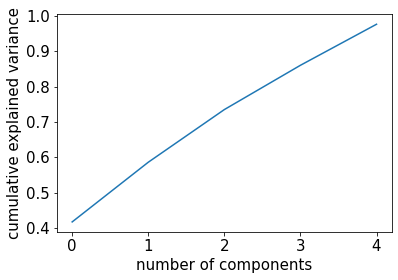

In [22]:
pipe = Pipeline([
        ('scale', StandardScaler()),
        ('reduce_dims', PCA(n_components=n))]
        )
pipe.fit(df_model[all_terms])

plt.plot(np.cumsum(pipe['reduce_dims'].explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [23]:
f = 'log_gdp ~ log_GFCF + log_wkn_population + 1 + ' + ' + '.join([f'pca_{i}' for i in range(n)])
y, X = patsy.dmatrices(f, df_model.set_index(['country','year']),  return_type='dataframe')

model = RandomEffects(y,X)
results = model.fit()
results.summary

/home/ubuntu/.local/lib/python3.7/site-packages/linearmodels/panel/data.py:98: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(s):


Dep. Variable:,log_gdp,R-squared:,0.6208
Estimator:,RandomEffects,R-squared (Between):,0.4989
No. Observations:,2511,R-squared (Within):,0.6280
Date:,"Wed, Aug 18 2021",R-squared (Overall):,0.4935
Time:,10:50:31,Log-likelihood,-985.37
Cov. Estimator:,Unadjusted,,
,,F-statistic:,585.41
Entities:,171,P-value,0.0000
Avg Obs:,14.684,Distribution:,"F(7,2503)"
Min Obs:,0.0000,,
Max Obs:,16.000,F-statistic (robust):,565.51


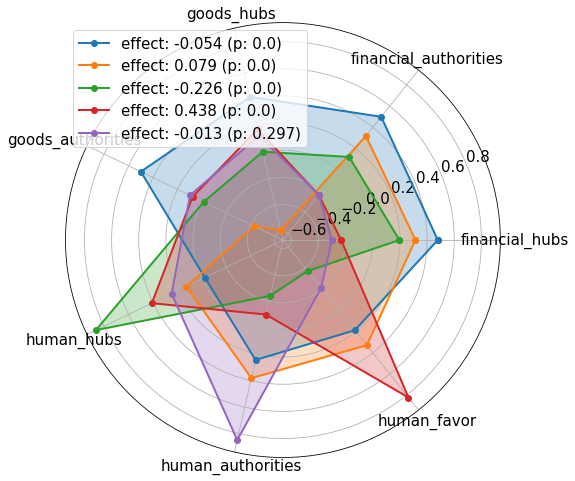

In [24]:
df_radar = pd.DataFrame(pipe['reduce_dims'].components_, columns = all_terms)
df_radar.loc[:,'coefs'] = pd.Series(results.params[[f'pca_{i}' for i in range(n)]].values)
df_radar['pvalues'] = pd.Series(results.pvalues[[f'pca_{i}' for i in range(n)]].values)

labels = all_terms.copy()
stats = pipe['reduce_dims'].components_[0]

angles=np.linspace(0, 2*np.pi, len(all_terms), endpoint=False)

fig=plt.figure(figsize = (8,8))
ax = fig.add_subplot(111, polar=True)

for i in range(n):
    stats = df_radar.loc[i,all_terms]
    c = round(df_radar.loc[i,'coefs'], 3)
    p =  round(df_radar.loc[i,'pvalues'], 3)
    ax.plot(np.concatenate((angles,[angles[0]])), np.concatenate((stats,[stats[0]])), 
            'o-', 
            linewidth=2, 
            label = f'effect: {c} (p: {p})'
)
    ax.fill(angles, stats, alpha=0.25)
plt.legend()
ax.set_thetagrids(angles * 180/np.pi, labels)
ax.grid(True)

## Time series

In [25]:
lagged_all_terms_list = ['delta_financial_' + c for c in reduced_centralities] + ['delta_human_' + c for c in reduced_centralities]
lagged_all_terms_list = ' + '.join(lagged_all_terms_list)

In [26]:
model = IV2SLS(df_model.delta_log_output, df_model[['financial_' + c for c in reduced_centralities] + ['human_' + c for c in reduced_centralities] + ['constant']], df_model.lag_log_output, df_model.lag_log2_output)
results = model.fit()
results.summary

/home/ubuntu/.local/lib/python3.7/site-packages/linearmodels/iv/data.py:25: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if is_categorical(s):
/home/ubuntu/.local/lib/python3.7/site-packages/linearmodels/utility.py:549: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  warnings.warn(missing_value_warning_msg, MissingValueWarning)


<class 'linearmodels.compat.statsmodels.Summary'>
"""
                          IV-2SLS Estimation Summary                          
==============================================================================
Dep. Variable:       delta_log_output   R-squared:                      0.0466
Estimator:                    IV-2SLS   Adj. R-squared:                 0.0440
No. Observations:                2560   F-statistic:                    110.97
Date:                Wed, Aug 18 2021   P-value (F-stat)                0.0000
Time:                        10:50:32   Distribution:                  chi2(7)
Cov. Estimator:                robust                                         
                                                                              
                                   Parameter Estimates                                   
=========================================================================================
                       Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
-----------------------------------------------------------------------------------------
financial_hubs           -0.0703     0.0409    -1.7200     0.0854     -0.1503      0.0098
financial_authorities     0.0738     0.0422     1.7499     0.0801     -0.0089      0.1565
financial_favor          -0.0205     0.0084    -2.4346     0.0149     -0.0370     -0.0040
human_hubs               -0.5048     0.1802    -2.8018     0.0051     -0.8580     -0.1517
human_authorities        -0.0340     0.0704    -0.4832     0.6290     -0.1720      0.1040
human_favor               0.0010     0.0011     0.8605     0.3895     -0.0012      0.0032
constant                  0.8051     0.2007     4.0121     0.0001      0.4118      1.1984
lag_log_output           -0.0180     0.0053    -3.3847     0.0007     -0.0284     -0.0076
=========================================================================================

Endogenous: lag_log_output
Instruments: lag_log2_output
Robust Covariance (Heteroskedastic)
Debiased: False
"""

In [27]:
print(results.summary.as_latex())

\begin{center}
\begin{tabular}{lclc}
\toprule
\textbf{Dep. Variable:}         & delta\_log\_output & \textbf{  R-squared:         } &      0.0466      \\
\textbf{Estimator:}             &      IV-2SLS       & \textbf{  Adj. R-squared:    } &      0.0440      \\
\textbf{No. Observations:}      &        2560        & \textbf{  F-statistic:       } &      110.97      \\
\textbf{Date:}                  &  Wed, Aug 18 2021  & \textbf{  P-value (F-stat)   } &      0.0000      \\
\textbf{Time:}                  &      10:50:32      & \textbf{  Distribution:      } &     chi2(7)      \\
\textbf{Cov. Estimator:}        &       robust       & \textbf{                     } &                  \\
\bottomrule
\end{tabular}
\begin{tabular}{lcccccc}
                                & \textbf{Parameter} & \textbf{Std. Err.} & \textbf{T-stat} & \textbf{P-value} & \textbf{Lower CI} & \textbf{Upper CI}  \\
\midrule
\textbf{financial\_hubs}        &      -0.0703       &       0.0409       &     -1.7200    